In [1]:
import numpy as np 
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import random
import json
from sklearn.model_selection import train_test_split
import shutil
import yaml
plt.style.use("ggplot")

In [2]:
dataset_path = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset"

In [3]:
annotation_list = glob(f"{dataset_path}/ArTaxOr/*/annotations/*.json")

In [4]:
data = pd.DataFrame()
data["annotation_dir"] = annotation_list

In [5]:
data.head()

,annotation_dir
0,/kaggle/input/arthropod-taxonomy-orders-object...
1,/kaggle/input/arthropod-taxonomy-orders-object...
2,/kaggle/input/arthropod-taxonomy-orders-object...
3,/kaggle/input/arthropod-taxonomy-orders-object...
4,/kaggle/input/arthropod-taxonomy-orders-object...


In [6]:
def read_json_data(jsonfile):
    rows = {"id": [], "img_dir":[] ,"img_w":[] , "img_h" : [], "x": [], "y": [], "w": [], "h": [],
            "sp_type": [] ,"xc":[] , "yc":[], "bb_height" : [] , "bb_width": [] , "bb_left":[] , "bb_top":[]}
    
    # read file
    json_f = open(jsonfile)
    json_f = json.load(json_f)
    
    for region in json_f["regions"]:
        
        id = json_f["asset"]["id"]
        
        img_dir = json_f["asset"]["path"][16:]
        
        sp_type = region["tags"][0]
        
        img_w = json_f["asset"]["size"]["width"]
        img_h = json_f["asset"]["size"]["height"]
        
        x = region["boundingBox"]["left"]
        y = region["boundingBox"]["top"]
        w = region["boundingBox"]["width"]
        h = region["boundingBox"]["height"]
        
        # Normalize Bounding Box 
        bb_height = region["boundingBox"]["height"] / img_h
        bb_width = region["boundingBox"]["width"] / img_w
        
        bb_left = region["boundingBox"]["left"] / img_w
        bb_top = region["boundingBox"]["top"] / img_h
        
        xcenter = region['boundingBox']['left']/img_w+0.5*bb_width
        ycenetr = region['boundingBox']['top']/img_h+0.5*bb_height
        
        rows["id"].append(id)
        rows["img_dir"].append(img_dir)
        rows["sp_type"].append(sp_type)
        rows["img_w"].append(img_w)
        rows["img_h"].append(img_h)
        
        rows["x"].append(x) # xmin
        rows["y"].append(y) # ymin
        rows["w"].append(w) # width of bounding box
        rows["h"].append(h) # height of bouding box
        
        rows["bb_height"].append(bb_height)
        rows["bb_width"].append(bb_width)
        rows["bb_left"].append(bb_left)
        rows["bb_top"].append(bb_top)
        rows["xc"].append(xcenter)
        rows["yc"].append(ycenetr)

    return rows

In [7]:
#coulmns = ["img_dir" , "sp_type" , "hight" , "width" , "left" ,"top"]
data_list = []

for json_file in tqdm(data["annotation_dir"]):
    rows = read_json_data(json_file)
    data_list.append(pd.DataFrame.from_dict(rows))  # Convert rows to DataFrame and add to list

# Concatenate all data frames in the list into a single DataFrame
df = pd.concat(data_list, ignore_index=True)

  0%|          | 0/15376 [00:00<?, ?it/s]

In [8]:
df.head()

,id,img_dir,img_w,img_h,x,y,w,h,sp_type,xc,yc,bb_height,bb_width,bb_left,bb_top
0,c8b97a82904b52366583d8a2250320a5,Coleoptera/34f2f8c20c6c.jpg,3486,2324,1508.758098,465.453400,824.050999,670.523268,Coleoptera,0.550999,0.344542,0.288521,0.236389,0.432805,0.200281
1,b34bd7718c727caaf7d25cc58a8e2278,Coleoptera/5b61c3175e47.jpg,2848,2136,350.885057,194.367816,534.000000,560.597701,Coleoptera,0.216954,0.222222,0.262452,0.187500,0.123204,0.090996
2,b34bd7718c727caaf7d25cc58a8e2278,Coleoptera/5b61c3175e47.jpg,2848,2136,2073.597701,38.873563,223.011494,335.540230,Coleoptera,0.767241,0.096743,0.157088,0.078305,0.728089,0.018199
3,b34bd7718c727caaf7d25cc58a8e2278,Coleoptera/5b61c3175e47.jpg,2848,2136,438.862069,1268.505747,327.356322,550.367816,Coleoptera,0.211566,0.722701,0.257663,0.114943,0.154095,0.593870
4,b34bd7718c727caaf7d25cc58a8e2278,Coleoptera/5b61c3175e47.jpg,2848,2136,899.206897,529.908046,775.425287,975.931034,Coleoptera,0.451868,0.476533,0.456897,0.272270,0.315733,0.248084


In [9]:
def display_random_imgs(df , rows , cols):
    idxs = random.sample(df.index.tolist() , rows*cols)
    fig , ax = plt.subplots(rows , cols ,figsize = (10,10))
    if rows*cols != 1:
        for count , axs in enumerate(ax.flatten()):

            path = os.path.join(f'{dataset_path}/ArTaxOr', df['img_dir'].iloc[idxs[count]])
            patch = patches.Rectangle((df.bb_left.iloc[idxs[count]] * df.img_w.iloc[idxs[count]],
                                        df.bb_top.iloc[idxs[count]]* df.img_h.iloc[idxs[count]]),
                                        df.bb_width.iloc[idxs[count]]* df.img_w.iloc[idxs[count]],
                                        df.bb_height.iloc[idxs[count]]* df.img_h.iloc[idxs[count]],
                                        linewidth=1, edgecolor='r', facecolor='none')
            img = plt.imread(path)
            axs.imshow(img)
            axs.add_patch(patch)
            axs.axis('off')
            axs.title.set_text(df.sp_type.iloc[idxs[count]])

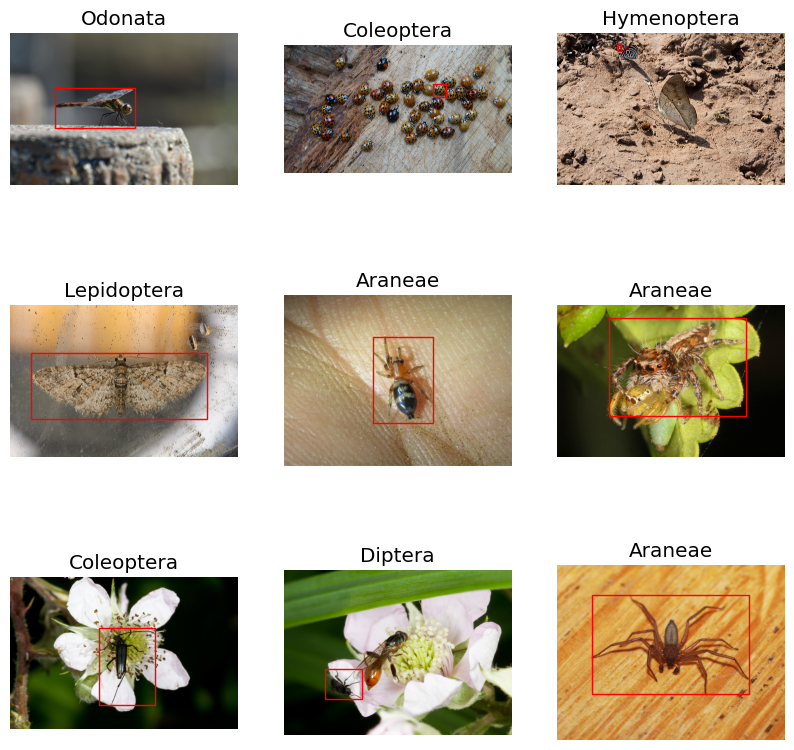

In [10]:
display_random_imgs(df, 3, 3)

In [11]:
from sklearn.model_selection import train_test_split

# Initial split: 80% for training, 20% for temp
train, temp = train_test_split(df, test_size=0.2, random_state=42)

# Split the temp set: 1/2 of temp for test, 1/2 of temp for validation (1:1 ratio in temp)
test, valid = train_test_split(temp, test_size=0.5, random_state=42)

In [12]:
train.shape, test.shape, valid.shape

((15684, 15), (1960, 15), (1961, 15))

In [13]:
HOME = os.getcwd()
HOME

'/kaggle/working'

In [14]:
train.to_csv(f'{HOME}/train_medata.csv', index=False)
test.to_csv(f'{HOME}/test_medata.csv', index=False)
valid.to_csv(f'{HOME}/valid_medata.csv', index=False)

In [15]:
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/valid

In [16]:
def add_data_to_folder(file_type, data):
    # Create directories for images and labels if they don’t exist
    os.makedirs(f"{HOME}/data/{file_type}/images", exist_ok=True)
    os.makedirs(f"{HOME}/data/{file_type}/labels", exist_ok=True)

    for index, row in tqdm(data.iterrows(), total=len(data)):
        # Copy the image to the images folder
        shutil.copy(os.path.join(f'{dataset_path}/ArTaxOr', row["img_dir"]), f"{HOME}/data/{file_type}/images")

        # Create the text file in the labels folder
        txt_filename = f"{HOME}/data/{file_type}/labels/{row.img_dir.split('/')[-1][:-4]}.txt"
        with open(txt_filename, "w") as f:
            # Write the annotations in the required format
            f.write(f"{row['sp_type']} {row['xc']} {row['yc']} {row['bb_width']} {row['bb_height']}\n")

In [17]:
classes_name = ["Hymenoptera","Hemiptera","Lepidoptera","Coleoptera","Diptera","Araneae","Odonata"]
classes_num = [0,1,2,3,4,5,6]

# class_mapping = dict(zip(classes_num, classes_name))

# Thay đổi giá trị trong cột 'sp_type' theo ánh xạ
train['sp_type'] = train['sp_type'].replace(classes_name , classes_num)
test['sp_type'] = test['sp_type'].replace(classes_name , classes_num)
valid['sp_type'] = valid['sp_type'].replace(classes_name , classes_num)

/tmp/ipykernel_23/1136637513.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['sp_type'] = train['sp_type'].replace(classes_name , classes_num)
/tmp/ipykernel_23/1136637513.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['sp_type'] = test['sp_type'].replace(classes_name , classes_num)
/tmp/ipykernel_23/1136637513.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

In [18]:
add_data_to_folder("train" , train)
add_data_to_folder("test" , test)
add_data_to_folder("valid" , valid)

  0%|          | 0/15684 [00:00<?, ?it/s]

  0%|          | 0/1960 [00:00<?, ?it/s]

  0%|          | 0/1961 [00:00<?, ?it/s]

In [19]:
# create yml file
yaml_dict = dict(
    train = '../data/train',
    test = '../data/test',
    val = '../data/valid',
    
    nc    = len(classes_num), # number of classes
    names = classes_name # classes
    )

with open('/kaggle/working/data/data.yaml', 'w') as outfile:
    yaml.dump(yaml_dict, outfile, default_flow_style=False)

%cat /kaggle/working/data/data.yaml

names:
- Hymenoptera
- Hemiptera
- Lepidoptera
- Coleoptera
- Diptera
- Araneae
- Odonata
nc: 7
test: ../data/test
train: ../data/train
val: ../data/valid


# YOLOv10

In [20]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git
!pip install -q supervision
!pip install albumentations==1.4
!pip install -U ultralytics "ray[tune]"
!pip uninstall -y wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.17
    Uninstalling albumentations-1.4.17:
      Successfully uninstalled albumentations-1.4.17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 26.5 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.1.34
    Uninstalling ultralytics-8.1.34:
      Successfully uninstalled ultralytics-8.1.34
  Attempting uninstall: ray
    Found existing installation: ray 2.24.0
    Uninstalling ray-2.24.0:
      Successfully uninstalled ray-2.24.0
Found existing installation: wandb 0.18.3
Uninstalling wandb-0.18.3:
  Successfully uninstalled wandb-0.18.3


In [21]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 11M
-rw-r--r-- 1 root root 11M May 26  2024 yolov10n.pt


In [22]:
!yolo task=detect mode=train epochs=50 batch=32 plots=True \
model={HOME}/weights/yolov10n.pt \
data={HOME}/data/data.yaml \
device=0,1

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
                                                 CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/weights/yolov10n.pt, data=/kaggle/working/data/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=(0, 1), workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio

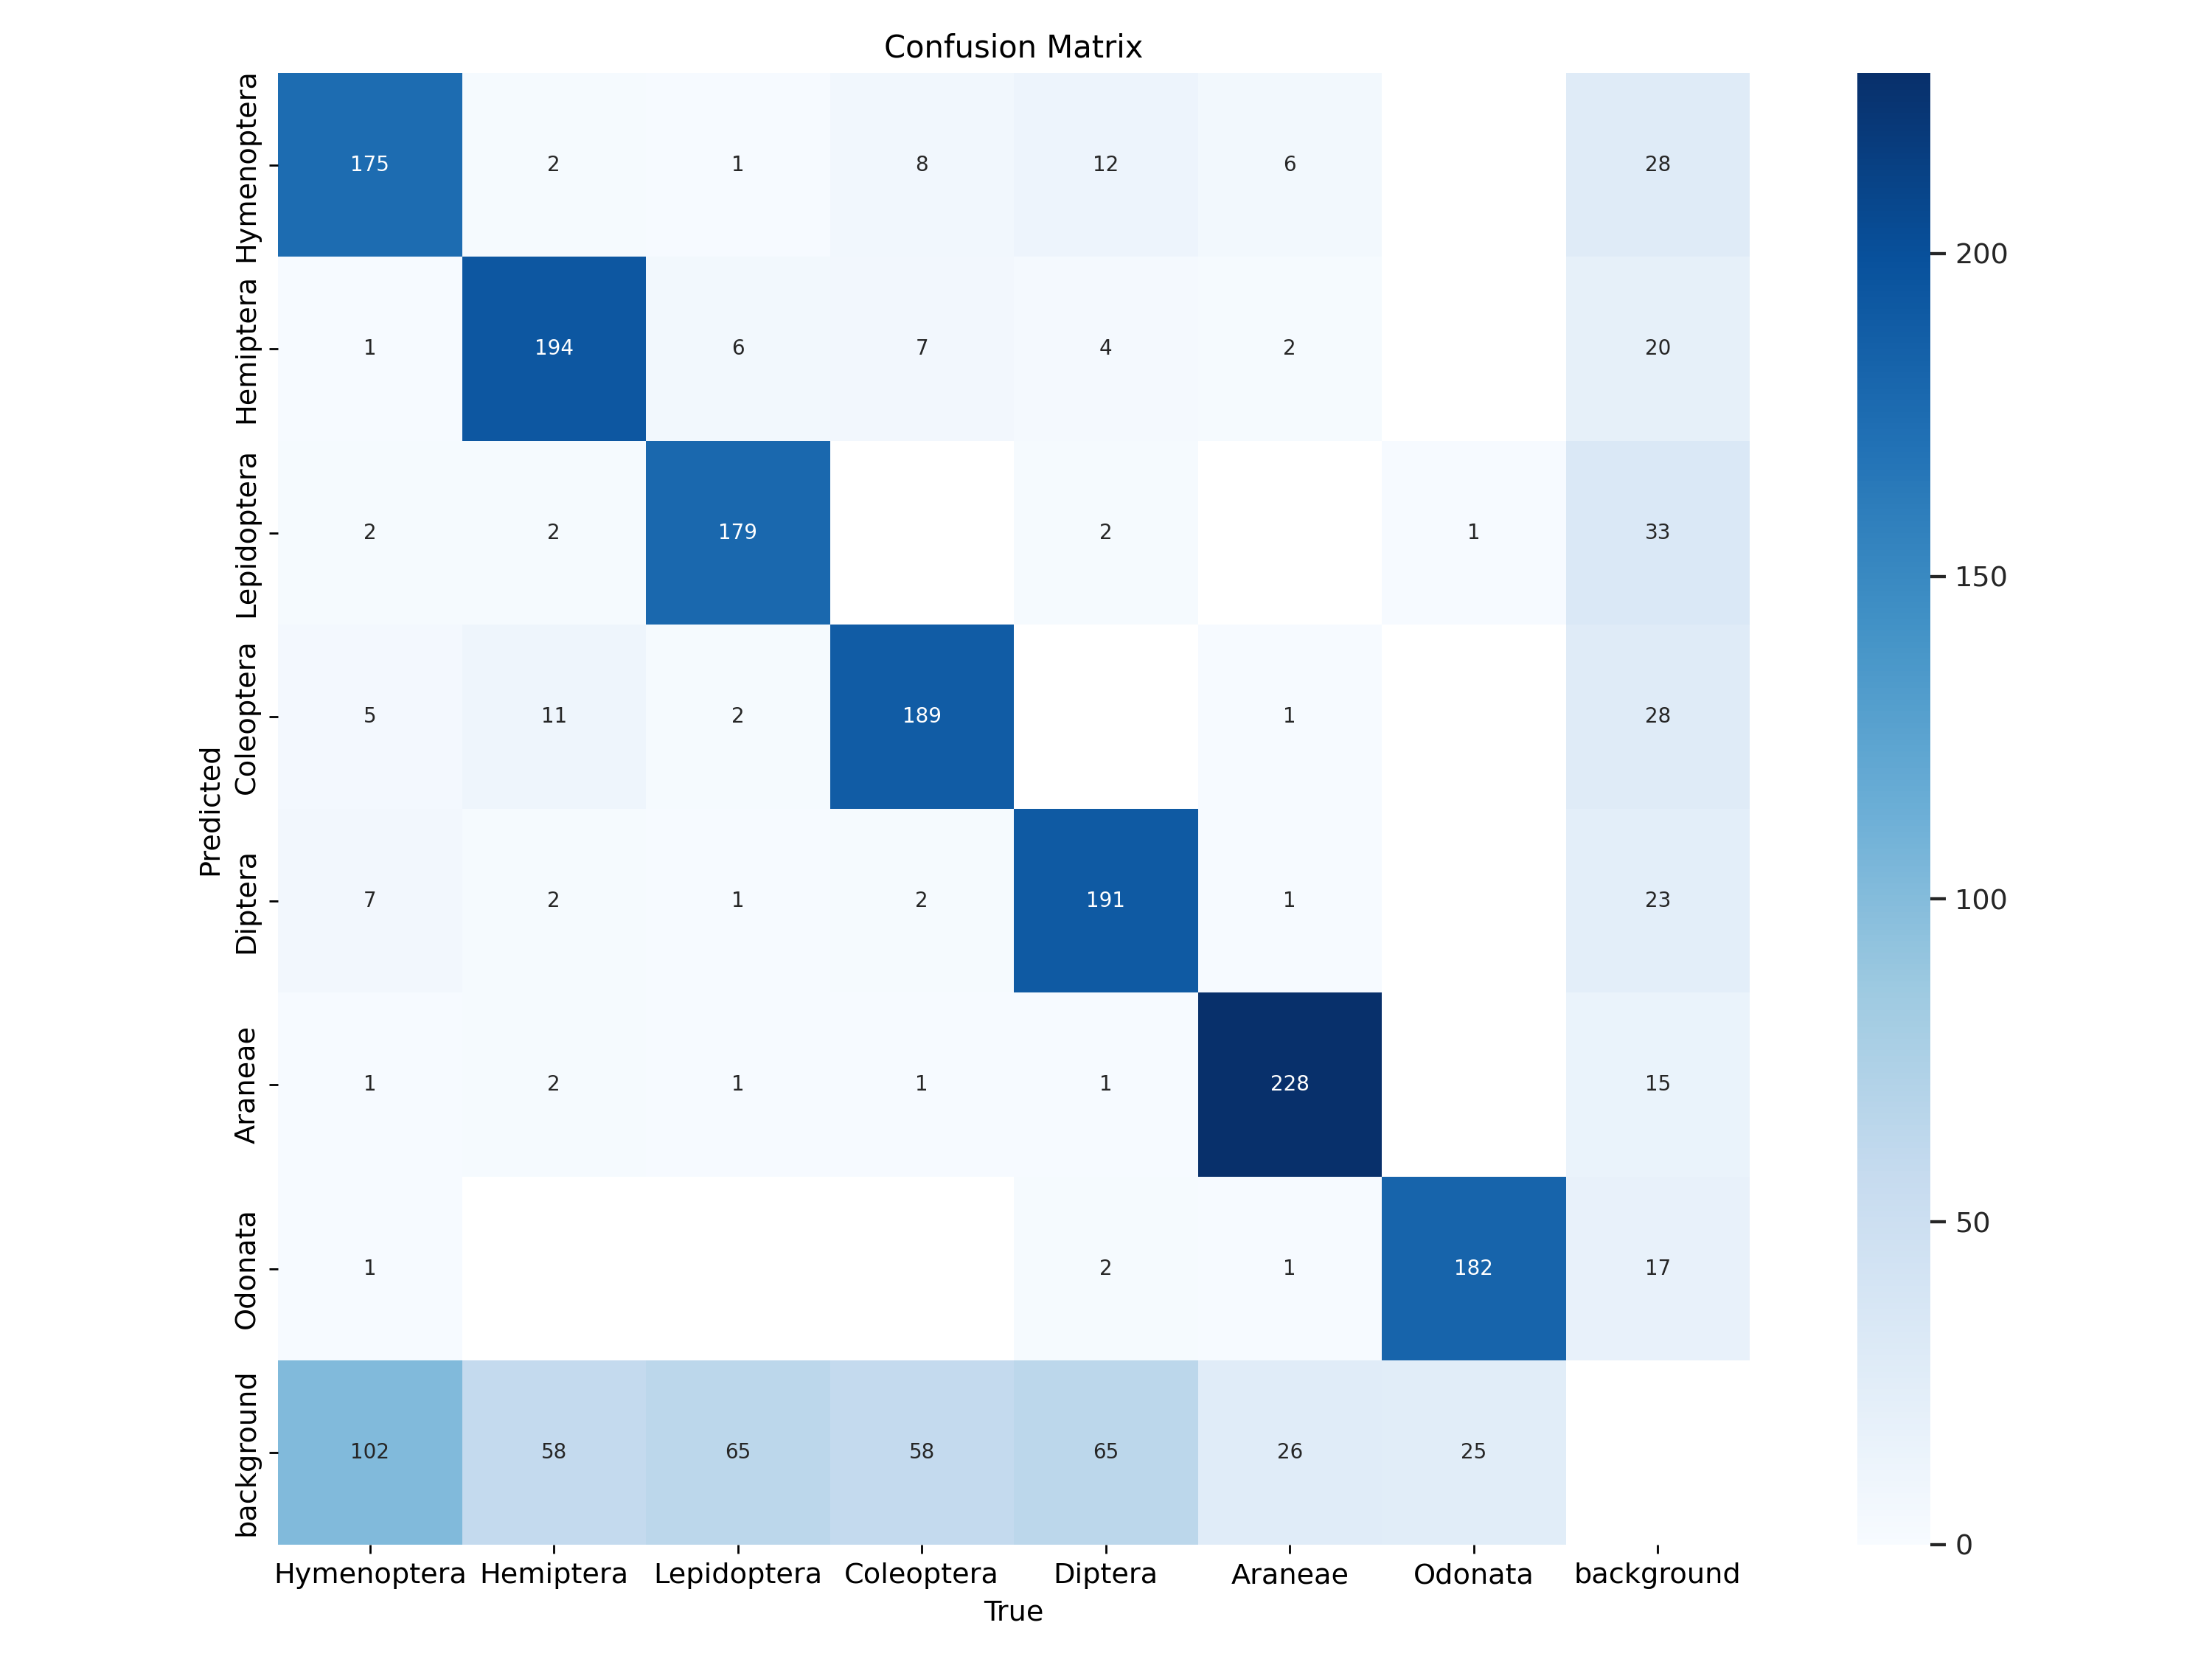

In [23]:
from IPython.display import Image
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=800)

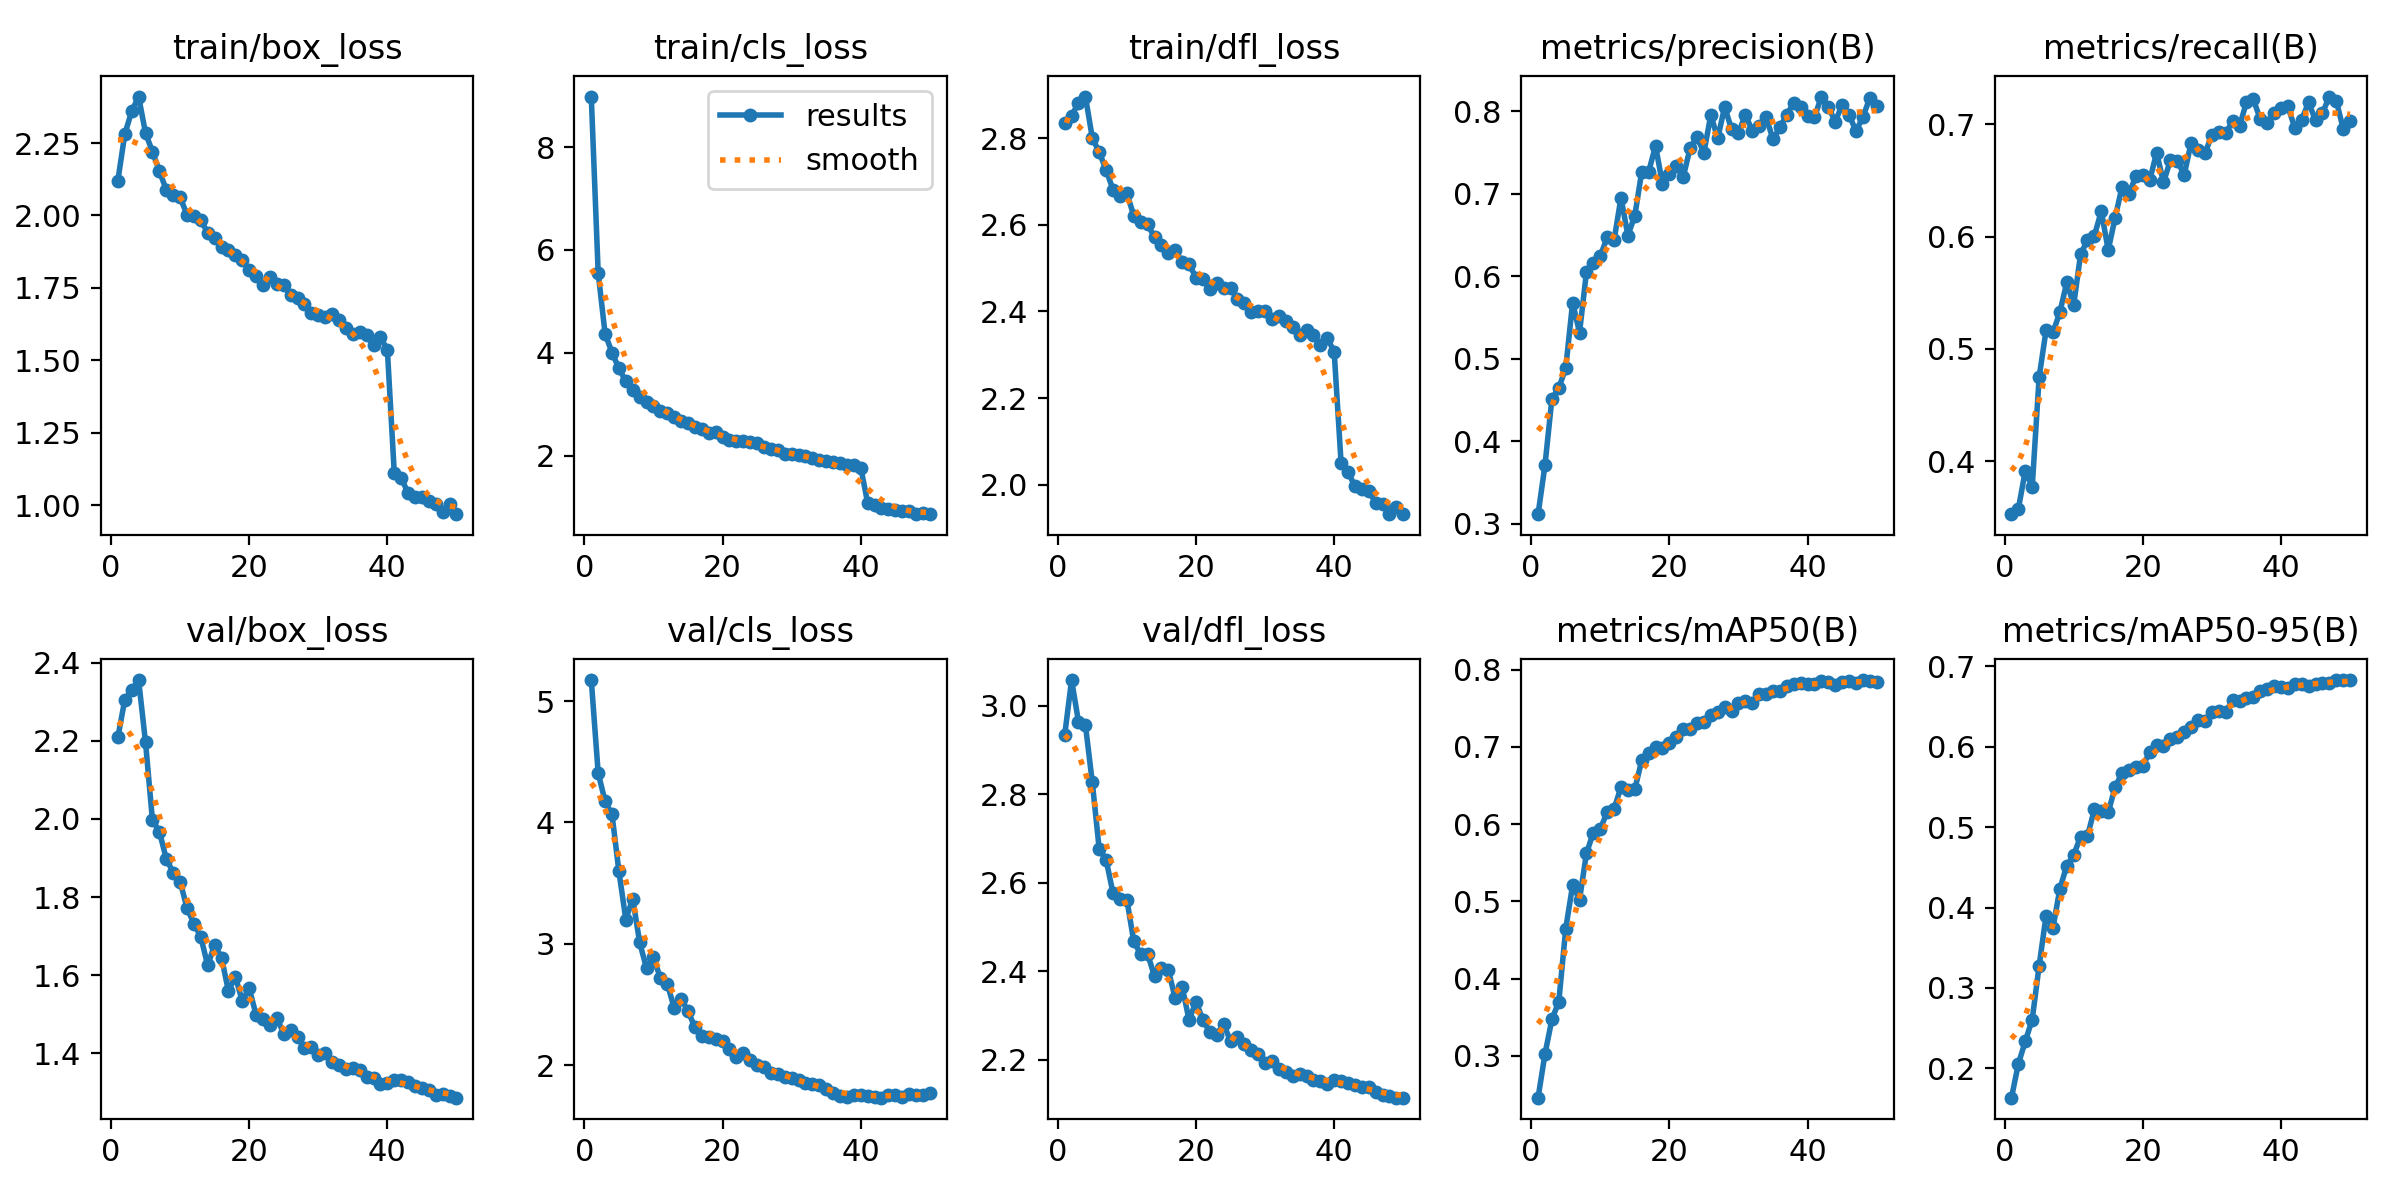

In [24]:
Image(filename=f'{HOME}/runs/detect/train/results.png', width=800)

In [25]:
from ultralytics import YOLO
import supervision as sv

model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{HOME}/data/valid/images",
    annotations_directory_path=f"{HOME}/data/valid/labels",
    data_yaml_path=f"{HOME}/data/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 448x640 (no detections), 43.7ms
Speed: 32.3ms preprocess, 43.7ms inference, 28.8ms postprocess per image at shape (1, 3, 448, 640)


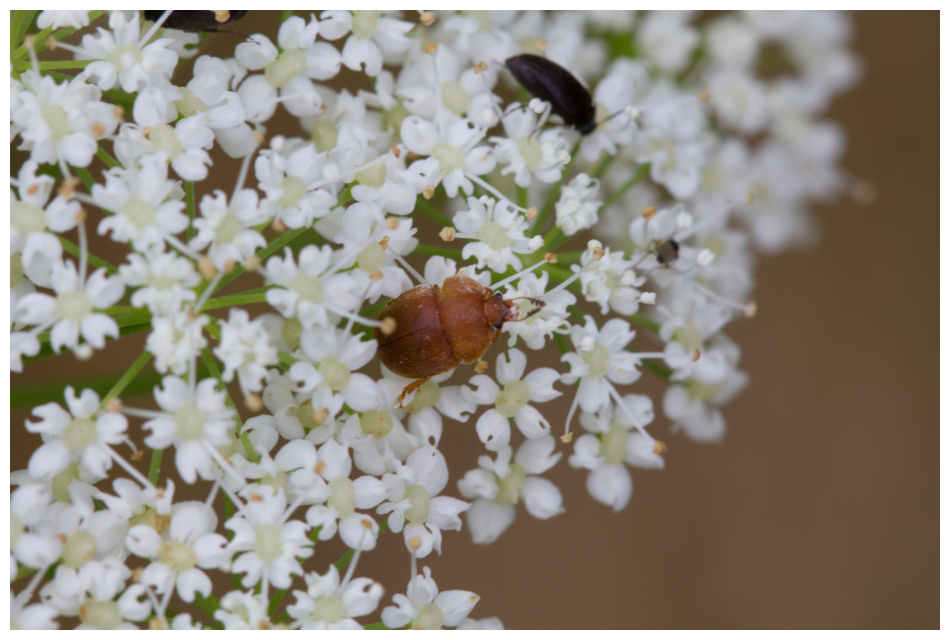

In [26]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [27]:
from ultralytics import YOLO

# Load a model
model = YOLO(f'{HOME}/runs/detect/train/weights/best.pt')  # load a custom model

# Validate the model
validation_results = model.val(data=f"{HOME}/data/data.yaml", imgsz=640, batch=32, conf=0.25, iou=0.5)  # no arguments needed, dataset and settings remembered

Ultralytics 8.3.39 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 285 layers, 2,697,146 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /kaggle/working/data/valid/labels.cache... 1835 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1835/1835 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:40<00:00,  1.44it/s]


                   all       1835       1835      0.815      0.696      0.792      0.722
           Hymenoptera        294        294       0.75      0.551      0.685      0.614
             Hemiptera        271        271      0.842       0.69      0.799       0.74
           Lepidoptera        255        255      0.726      0.647      0.705      0.641
            Coleoptera        265        265      0.803      0.647      0.773      0.681
               Diptera        277        277       0.83      0.646      0.786      0.731
               Araneae        265        265       0.91      0.844      0.894      0.804
               Odonata        208        208      0.845      0.846      0.898      0.844
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val


In [28]:
print(validation_results.box.map)  # map50-95
print(validation_results.box.map50)  # map50
print(validation_results.box.map75)  # map75
print(validation_results.box.maps)  # a list contains map50-95 of each category

0.7223039543985551
0.7915654156593916
0.752502093008025
[     0.6139     0.74041     0.64107     0.68083     0.73136     0.80423     0.84433]
